In [14]:

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [15]:

# Load the dataset
df = pd.read_csv('../Dataset/sp500_companies_with_growth_category.csv')


In [16]:

# Step 1: Remove only explicitly unwanted attributes 
columns_to_drop = ['Exchange', 'Shortname', 'Longname','Revenuegrowth','Longbusinesssummary']  
df = df.drop(columns=columns_to_drop)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             499 non-null    object 
 1   Sector             499 non-null    object 
 2   Industry           499 non-null    object 
 3   Currentprice       499 non-null    float64
 4   Marketcap          499 non-null    int64  
 5   Ebitda             470 non-null    float64
 6   City               499 non-null    object 
 7   State              479 non-null    object 
 8   Country            499 non-null    object 
 9   Fulltimeemployees  490 non-null    float64
 10  Weight             499 non-null    float64
 11  Growth_Category    499 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 46.9+ KB


In [17]:

# Step 2: Preliminary feature selection
# Identify remaining numerical and categorical features
numerical_features = ['Currentprice', 'Marketcap', 'Ebitda', 
                     'Fulltimeemployees', 'Weight']
categorical_features = ['Sector', 'Industry', 'City', 'State', 'Country', 'Symbol']


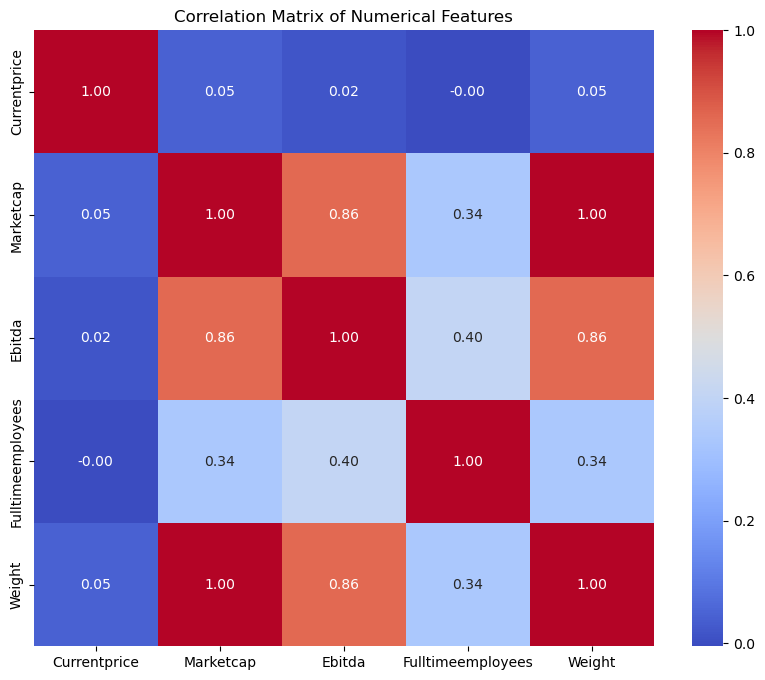

In [18]:

# Step 3: Feature correlation analysis
# Plot correlation matrix for numerical features
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.savefig('../Image/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


1. Here the r between 'Weight' and 'Marketcap' is 1, so we can just perserve one of them-'Weight'
2. R between 'Weight' and 'Ebitda' is 0.86, which is larger than 0.85, indicating that they are very relerant, so we delete 'Ebitda'

In [19]:
df = df.drop(columns=['Marketcap', 'Ebitda'])

In [20]:

# Step 4: Statistical significance testing for categorical features
# Chi-square test for categorical features
for cat_feature in categorical_features:
    encoder = LabelEncoder()
    encoded_feature = encoder.fit_transform(df[cat_feature].fillna('Missing'))
    chi2_stat, p_value = chi2(encoded_feature.reshape(-1, 1), df['Growth_Category'])
    print(f"{cat_feature} - Chi2 p-value: {p_value[0]:.4f}")


Sector - Chi2 p-value: 0.0000
Industry - Chi2 p-value: 0.0001
City - Chi2 p-value: 0.0000
State - Chi2 p-value: 0.0000
Country - Chi2 p-value: 0.9302
Symbol - Chi2 p-value: 0.0000


Here we can see the p-value of 'Country' is much larger than 0.05, so we can delete this feature

In [21]:
df = df.drop(columns=['Country'])

In [22]:

# Step 5: Validate hierarchical relationship (automatically remove redundant features)
def drop_redundant_features(df, parent, child):
    """If child uniquely maps to parent, then drop parent"""
    mapping = df.groupby(child)[parent].nunique()
    if mapping.max() == 1:
        print(f"True! {child} uniquely determines {parent}, dropping {parent}")
        return df.drop(columns=[parent])
    else:
        print(f"False! {mapping.sum()} {child} values map to multiple {parent} values, requires manual review")
        return df
    
# There are missing values in 'State', we drop the NaN and then check the relationship    
df_clean = df.dropna(subset=['State'])
df_clean = drop_redundant_features(df_clean, parent='Sector', child='Industry')
df_clean = drop_redundant_features(df_clean, parent='State', child='City')

True! Industry uniquely determines Sector, dropping Sector
False! 233 City values map to multiple State values, requires manual review


In [23]:
df = df.drop(columns=['Sector'])

In [24]:
# Step 6: Feature importance analysis between City and State
df_encoded = df.copy()
df_encoded['City'] = pd.factorize(df['City'])[0]
df_encoded['State'] = pd.factorize(df['State'])[0]

# Calculate mutual information between categorical features and target variable
model = RandomForestClassifier()
model.fit(df_encoded[['City', 'State']], df['Growth_Category'])
print("Importance of City:", model.feature_importances_[0])
print("Importance of State:", model.feature_importances_[1])

Importance of City: 0.6875267310163733
Importance of State: 0.3124732689836267


Here we drop the 'State' for following reasons:
- Importance score for 'City' is bigger than 'State'
- 'City' provide more specific info of location than 'State'
- There are some missing values in 'State' but not in 'City'

In [25]:
df = df.drop(columns=['State'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             499 non-null    object 
 1   Industry           499 non-null    object 
 2   Currentprice       499 non-null    float64
 3   City               499 non-null    object 
 4   Fulltimeemployees  490 non-null    float64
 5   Weight             499 non-null    float64
 6   Growth_Category    499 non-null    object 
dtypes: float64(3), object(4)
memory usage: 27.4+ KB


In [26]:
df.set_index('Symbol').to_csv("../Dataset/sp500_for_train.csv")